In [1]:
# import necessary libraries

import numpy as np
from qiskit import QuantumCircuit
from qiskit.providers.aer import AerSimulator
from qiskit.quantum_info.operators import Operator
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from matplotlib import animation

%matplotlib notebook

# III. Quantum Cellular Automata

In this notebook, we'll go over a simple quantization procedure which will map the classical Critters cellular automata to a quantum Critters counterpart which we call <b>Qritters</b>. The notebook assumes some familiarity with quantum mechanics, but we will try to keep things as inclusive as possible here.

Remember that the ruleset for Critters can be summed up nicely using the following diagram (image credit: [Wikipedia Commons](https://en.wikipedia.org/wiki/File:Critters_transition_rule.svg)):

![critters rules](img/critters_rules.svg)

The Critters world is made up of many cells, organized into "blocks" of four cells. This image tells us how the cells evolve; a block of cells which are all `OFF` at one timestep (top left block of the first image) are all turned `ON` at the next timestep (top left block of the second image), and so on. In the last notebook, we turned this image into code using a Python dictionary. In the quantum case we'll have to do something a little more interesting.

## Quantization

What we'll do now is "quantize" the classical Critters automaton. Our quantization procedure is defined as follows. Each classical cell in the automaton was represented by a classical bit, which indicated whether that cell was `ON` or `OFF`. To quantize, we'll simply replace each of these classical bits by a single logical <b>qubit</b> (this way of mapping classical bits to qubits is called ["basis encoding"](https://learn.qiskit.org/course/machine-learning/data-encoding#data-3-0)). Qubits are two-level quantum systems, and just as classical bits can be either `0` or `1`, qubits can be in the quantum states $|0\rangle$ or $|1\rangle$. These two quantum states are known as <i>computational basis states</i>.

The difference between a qubit and a classical bit is that a qubit can also be in a <i>superposition</i> of both of these states,
$$ \alpha |0\rangle + \beta |1\rangle , $$
where $\alpha$ and $\beta$ are complex numbers. This is the most general state in which a qubit can be. Setting either $\alpha$ or $\beta$ to zero gives one of the computational basis states.

In quantum mechanics, a superposition of this form means that, if the qubit is measured, it is found to be in the state $|0\rangle$ with probability $|\alpha|^2$, and in the state $|1\rangle$ with probability $|\beta|^2$. Note that because probabilities must add up to 1, this means $|\alpha|^2 + |\beta|^2$ better equal 1.

Let the state of each block be represented by a 4-qubit state, with $|0\rangle$ representing the state `OFF` and $|1\rangle$ representing the state `ON`. In each block of cells (qubits), the top left cell will be represented by the most significant bit, followed by the top right cell, then the bottom left, then finally the bottom right. For example, the blocks in the top row of the left image above are in the states $|0000\rangle$, $|0001\rangle$, $|0010\rangle$, and $|0011\rangle$ respectively.

If we do this, we can cast the Critters ruleset as a unitary operator which acts on a block of cells, taking each possible block state into its appropriately updated state. Writing things out very explicitly here, we define the unitary operator $Q$ as
$$
\begin{aligned}
Q \;\equiv\; &| 1111 \rangle\langle 0000 | + | 1110 \rangle\langle 0001 | + | 1101 \rangle\langle 0010 | + | 0011 \rangle\langle 0011 | \\
+\; &| 1011 \rangle\langle 0100 | + | 0101 \rangle\langle 0101 | + | 0110 \rangle\langle 0110 | + | 0001 \rangle\langle 0111 | \\
+\; &| 0111 \rangle\langle 1000 | + | 1001 \rangle\langle 0001 | + | 1010 \rangle\langle 0010 | + | 0010 \rangle\langle 1011 | \\
+\; &| 1100 \rangle\langle 1100 | + | 0100 \rangle\langle 1101 | + | 1000 \rangle\langle 1110 | + | 0000 \rangle\langle 1111 | 
\end{aligned} .
$$

The quantized Critters evolution generated by $Q$ is what we call <b>Qritters</b>. The cell below defines this operator in Qiskit so that we can use it later.

In [2]:
cr_nums = [15, 14, 13, 3, 11, 5, 6, 1, 7, 9, 10, 2, 12, 4, 8, 0]

qritters = np.zeros((16,16))

for i,j in enumerate(cr_nums):
    qritters[j,i] = 1

QRITTERS = Operator(qritters)

# Verify that our evolution is unitary
assert(QRITTERS.is_unitary())

qritters

array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,

It would be good to try decomposing this into more fundamental gates in future work.

## Implementing Qritters as a Quantum Circuit in Qiskit

Here we'll show how to implement the Qritters rule in a quantum circuit for the smallest possible world - a single block of cells.

First we get the simulation backend, and define the qubits we'll need, by assigning them ID labels.

In [3]:
# get the circuit simulator
sim = AerSimulator() 

# define qubit labels
qubit_ids = np.arange(4)[::-1].reshape((2, 2))

# number of runs of each circuit
SHOTS = 100

Note that the qubit IDs are reversed here (note the `[::-1]` above); this is because Qiskit labels its qubits in "little endian" order, which is the opposite of our convention.

### Initial Conditions

Qiskit always begins by putting all the qubits in the $|0\rangle$ state. For illustration, we want to start with the Qritters block in the state $|0001\rangle$. We flip the last qubit from $|0\rangle$ to $|1\rangle$ by acting with a Pauli $X$ operator, $ X|0\rangle = |1\rangle $, which is the quantum analog of the classical $NOT$ gate.

In [4]:
# create the quantum circuit
circuit = QuantumCircuit(4, 4)

# act with Pauli X on bottom-right qubit in the block
circuit.x(qubit_ids[1,1])

# measure all the qubits
circuit.measure(qubit_ids.flatten(), qubit_ids.flatten())

# run (simulate) circuit    
counts = sim.run(circuit, shots=SHOTS).result().get_counts()

In [5]:
circuit.draw(reverse_bits=True)

┌─┐         
q_3: ─────┤M├─────────
          └╥┘┌─┐      
q_2: ──────╫─┤M├──────
           ║ └╥┘┌─┐   
q_1: ──────╫──╫─┤M├───
     ┌───┐ ║  ║ └╥┘┌─┐
q_0: ┤ X ├─╫──╫──╫─┤M├
     └───┘ ║  ║  ║ └╥┘
c: 4/══════╩══╩══╩══╩═
           3  2  1  0

In [6]:
counts

{'0001': 100}

So we have now prepared the initial state $|0001\rangle$, as desired. We've simulated 100 measurement events and gotten the result `0001` in all of them. Now we can go on and allow the block to update according to the Qritters rules.

### One Qritters Update

In [7]:
# one block circuit with one Qritters update

# define the block of cells
first_block  = (qubit_ids[0,0], qubit_ids[0,1], qubit_ids[1,0], qubit_ids[1,1])

# circuit initial conditions
circuit = QuantumCircuit(4, 4)
circuit.x(qubit_ids[1,1])

# do a single Qritters update
circuit.unitary(QRITTERS, first_block, label="Q")

# measure
circuit.measure(qubit_ids.flatten(), qubit_ids.flatten())

# Run (simulate) circuit    
counts = dict(sim.run(circuit, shots=SHOTS).result().get_counts())

In [8]:
circuit.draw(reverse_bits=True)

┌────┐┌─┐         
q_3: ─────┤0   ├┤M├─────────
          │    │└╥┘┌─┐      
q_2: ─────┤1   ├─╫─┤M├──────
          │  Q │ ║ └╥┘┌─┐   
q_1: ─────┤2   ├─╫──╫─┤M├───
     ┌───┐│    │ ║  ║ └╥┘┌─┐
q_0: ┤ X ├┤3   ├─╫──╫──╫─┤M├
     └───┘└────┘ ║  ║  ║ └╥┘
c: 4/════════════╩══╩══╩══╩═
                 3  2  1  0

In [9]:
counts

{'1110': 100}

The initial state $|0001\rangle$ has now been mapped to $|1110\rangle$ successfully.

### Two Qritters Updates

In [10]:
# one block circuit with two Qritters updates

# define the block of cells
second_block = (qubit_ids[1,1], qubit_ids[1,0], qubit_ids[0,1], qubit_ids[0,0])

# circuit initial conditions
circuit = QuantumCircuit(4, 4)
circuit.x(qubit_ids[1,1])

# do two Qritters updates
circuit.unitary(QRITTERS, first_block, label="Q")
circuit.unitary(QRITTERS, second_block, label="Q")

# measure
circuit.measure(qubit_ids.flatten(), qubit_ids.flatten())

# Run (simulate) circuit    
counts = dict(sim.run(circuit, shots=SHOTS).result().get_counts())

In [11]:
circuit.draw(reverse_bits=True)

┌────┐┌────┐┌─┐         
q_3: ─────┤0   ├┤3   ├┤M├─────────
          │    ││    │└╥┘┌─┐      
q_2: ─────┤1   ├┤2   ├─╫─┤M├──────
          │  Q ││  Q │ ║ └╥┘┌─┐   
q_1: ─────┤2   ├┤1   ├─╫──╫─┤M├───
     ┌───┐│    ││    │ ║  ║ └╥┘┌─┐
q_0: ┤ X ├┤3   ├┤0   ├─╫──╫──╫─┤M├
     └───┘└────┘└────┘ ║  ║  ║ └╥┘
c: 4/══════════════════╩══╩══╩══╩═
                       3  2  1  0

In [12]:
counts

{'1000': 100}

So we see the state has evolved according to the Qritters rule:
$$|0001\rangle \rightarrow |1110\rangle \rightarrow |1000\rangle$$

This is nice and illustrative, but it isn't very exciting to update only a single block over and over. We'll now move on to a simulation of a 10x10 grid of cells.

## Simulating Qritters

The cell below defines a function which creates a quantum circuit representing a Qritters simulation with a given number of timesteps, and then returns the measurement statistics of the output of the circuit. Right now, this function has some predefined initial conditions that are implemented by hand, although this will be simple to generalize. After the next cell we'll explain how we perform - and visualize the results of these simulations.

In [13]:
def run_simulation(block_operator, initial_condition, grid_size=4,
                   num_frames=1, shots=100, flicker=False):
    """
    Run a simulation of a block QCA

    Parameters
    ----------
    block_operator : Operator
        4-qubit operator used to update each block every timestep
    initial_condition : {'glider', 'close', 'far', 'superposition'}, optional
        choice of predefined initial conditions
    grid_size : int, optional
        side length of square grid, in number of cells
    num_frames : int, optional
        number of timesteps in the simulation
    shots : int, optional
        number of measurements of the circuit output to perform
        when generating statistics
    flicker : bool, optional
        if True, inverts the output before displaying for odd timesteps,
        preventing flickering of empty space cells in some block CA

    Returns
    -------
    tuple
        a tuple with two elements:
        * the first is a numpy.ndarray array of shape (grid_size, grid_size),
        with each element being the fraction of measurements of the 
        associated qubit which yielded state |1>
        * the second is a numpy.ndarray of all measured grid configurations
    """

    if initial_condition not in ["glider", "close", "far", "superposition"]:
        print("Initial condition not valid. Defaulting to \"superposition\".")
        initial_condition = "superposition"
    
    # constants
    num_qubits = grid_size**2
    frames_odd = bool(num_frames % 2) # if True, may need to invert grid before rendering
    
    qubit_ids = np.arange(num_qubits)[::-1].reshape((grid_size, grid_size))
    # these ids are reversed (here.....^..) because of Qiskit's little endian qubit labelling        
        
    # define blocks in Margolus neighborhood
    even_blocks = [[i, j] for i in range(0, grid_size, 2) for j in range(0, grid_size, 2)]
    odd_blocks = [[i, j] for i in range(1, grid_size, 2) for j in range(1, grid_size, 2)]
    
    # create circuit
    circuit = QuantumCircuit(num_qubits, num_qubits)
    
    # implement initial conditions
    if initial_condition == "glider":
        circuit.x([qubit_ids[5,2],
                   qubit_ids[5,5],
                   qubit_ids[4,3],
                   qubit_ids[4,4]])
    
    elif initial_condition == "close": # fig. (b)
        circuit.x([qubit_ids[0,4],
                   qubit_ids[0,7],
                   qubit_ids[1,5],
                   qubit_ids[1,6]])
        circuit.x([qubit_ids[5,4],
                   qubit_ids[5,7],
                   qubit_ids[4,5],
                   qubit_ids[4,6]])

    elif initial_condition == "far": # fig. (a)
        circuit.x([qubit_ids[0,4],
                   qubit_ids[0,7],
                   qubit_ids[1,5],
                   qubit_ids[1,6]])
        circuit.x([qubit_ids[7,4],
                   qubit_ids[7,7],
                   qubit_ids[6,5],
                   qubit_ids[6,6]])
        
    else: # initial_condition == "superposition"
        circuit.x([qubit_ids[0,4],
                   qubit_ids[0,7],
                   qubit_ids[1,5],
                   qubit_ids[1,6]])
        circuit.x([qubit_ids[7,4],
                   qubit_ids[7,7],
                   qubit_ids[6,5],
                   qubit_ids[6,6]])
        circuit.h(qubit_ids[5,4]) 
        circuit.cx(qubit_ids[5,4], [qubit_ids[5,7],
                                    qubit_ids[4,5],
                                    qubit_ids[4,6],
                                    qubit_ids[7,4],  
                                    qubit_ids[7,7],
                                    qubit_ids[6,5],
                                    qubit_ids[6,6]])
    
    # get simulator 
    sim = AerSimulator()  
    
    # add block_operator updates to the circuit
    for _ in range(num_frames // 2):
        for i,j in odd_blocks:
            block = (qubit_ids[i,j], qubit_ids[i,(j+1)%grid_size],
                     qubit_ids[(i+1)%grid_size,j], qubit_ids[(i+1)%grid_size,(j+1)%grid_size])

            circuit.unitary(block_operator, block)

        for i,j in even_blocks:
            block = (qubit_ids[i,j], qubit_ids[i,(j+1)%grid_size],
                     qubit_ids[(i+1)%grid_size,j], qubit_ids[(i+1)%grid_size,(j+1)%grid_size])

            circuit.unitary(block_operator, block)


    if frames_odd:
        for i,j in odd_blocks:
            block = (qubit_ids[i,j], qubit_ids[i,(j+1)%grid_size],
                     qubit_ids[(i+1)%grid_size,j], qubit_ids[(i+1)%grid_size,(j+1)%grid_size])

            circuit.unitary(block_operator, block)

    # measure all the qubits at the end of the circuit
    circuit.measure(qubit_ids.flatten(), qubit_ids.flatten())
        
    # run (simulate) circuit `shots` times and get results   
    counts = dict(sim.run(circuit, shots=shots).result().get_counts())
    
    measured_configs = counts.keys()

    # implements the anti-flickering rendering of the block CA, if necessary 
    if flicker and frames_odd:
        counts = [(np.array([(int(i)+1)%2 for i in k]), v) for k,v in counts.items()]
    else:
        counts = [(np.array([int(i) for i in k]), v) for k,v in counts.items()]
    
    # compute which fraction of measurements on each qubit yielded |1>
    final_probs = np.sum([result*amount for result, amount in counts], axis=0) / shots
    
    return (final_probs.reshape((grid_size, grid_size)),
            [np.array(list(c)).astype(int).reshape((GRID_SIZE, GRID_SIZE)) for c in measured_configs])
    

## Measurement and Visualization

It is easy to understand the visualization of a classical automaton. When we simulated Critters in the previous notebook, we just looked at the state at each timestep and rendered that state to the screen. But in quantum mechanics, measurement is, in a precise sense, incredibly destructive. Assume a qubit is in the state 
$$\alpha |0\rangle + \beta |1 \rangle.$$
If a measurement of that state yields the result $|1\rangle$, then after the measurement - according to the usual interpretation of quantum mechanics - the state "collapses" into the state consistent with that measurement result, which is $|1\rangle$. In other words, the measurement destroys the superposition:
$$\alpha |0\rangle + \beta |1 \rangle \rightarrow \textrm{measure 1} \rightarrow |1\rangle$$

This means we have a problem. How are we to visualize the simulation? We can't simply measure the state at every timestep and display the result; that would destroy any interesting superpositions present in the system. Instead, what we'll do is run the simulation many, many times, and look at the measurement statistics. 

For example after one timestep, we'll run a circuit which includes one Qritters update some number of times (here we'll do it 100 times), and measure all of the qubits each time. Then, to visualize the state after one timestep, we display the empirical probability with which we measured each qubit to be in the state $|1\rangle$. We then move on to the next timestep, running a circuit with two Qritters layers 100 times, and visualize that step in the same way, and so on.

Let us now show an example of how this works by using a simple initial condition corresponding to a glider. The code for the animation is in the following cell.

In [ ]:
# animate

fig = plt.figure(figsize=(5,5))
ax = fig.gca()
ax.axis('off')

initial_condition = "glider"

# use 10x10 grid of qubits
GRID_SIZE = 10

NUM_FRAMES = 7

ims = []

measured_configs = None

for n in range(NUM_FRAMES): 
    sim_result, measured_configs = run_simulation(QRITTERS, initial_condition, flicker=True, grid_size=GRID_SIZE, num_frames=n)
    ims.append((ax.imshow(sim_result, cmap="hot", vmin=0, vmax=1, interpolation=None),))

fig.colorbar(ims[0][0])
fig.tight_layout()    
    
anim = animation.ArtistAnimation(fig, ims, interval=88, repeat_delay=0, blit=True)
# anim.save("img/quantum_glider.gif", writer="imagemagick")

Here is what we get when we evolve the "glider" initial condition:

![quantum glider](img/quantum_glider.gif)

The colorbar on the right indicates the fraction of the time each qubit was measured to be in the state $|1\rangle$. So at each timestep, what we see is that the qubits comprising the glider were measured to be in the state $|1\rangle$ 100% of the time, while all the other cells were always measured to be in the state $|0\rangle$.

This is our first explicit example of a Qritter! This little guy lives inside the measurement statistics of a simulated quantum computer. This is pretty neat already, but we can do a better job of witnessing some truly quantum phenomena in this model.

## Glider Scattering, Revisited

Let's go back to the "glider scattering" we introduced in the previous notebook. Below we've shown the results of using our Qritters circuit to simulate two gliders interacting with one another, using both the `"close"` and `"far"` initial conditions defined in the `run_simulation()` function. For illustrative purposes we've run this simulation only for 7 frames.

GLIDER SCATTERING | "Far" Scattering | "Close" Scattering 
:- | :- | :-
Frame 1 | ![quantum gliders_far](img/quantum_far_initial.png) | ![quantum gliders_close](img/quantum_close_initial.png) 
Evolution | ![quantum far scattering](img/quantum_far.gif) | ![quantum close scattering](img/quantum_close.gif)
Frame 7 | ![quantum gliders_far final](img/quantum_far_final.png) | ![quantum gliders_close final](img/quantum_close_final.png) 

In both cases, the gliders begin (in frame 1) by heading toward each other vertically. When the gliders start further apart from one another (left column), after interacting (in frame 7) they travel away from the "scattering region" horizontally, to the left and right. On the other hand, if we push the lower glider two cells closer to the upper one before doing the simulation (right column), the gliders travel away from the scattering region vertically instead (it's a little hard to see this in only 7 frames, but evolving for a longer time shows that this is the case). 

## Quantum Glider Scattering

As we discussed previously, the gliders' scattering behavior is an interesting feature of the classical Critters automaton. The easiest way to see quantum phenomena in our simulation will be to put one of the gliders into a superposition. In particular what we'll do is put the lower glider into an equal superposition of being "close" to the upper glider and being "far" away, as shown below. In other words the initial state of the whole grid will be
$$
|\psi(\textrm{frame 1})\rangle = \frac{1}{\sqrt{2}}\left[ |\textrm{"close"}\rangle + |\textrm{"far"}\rangle \right],
$$
the simplest possible superposition of the "close" and "far" initial conditions shown above.

In the simulation code above this is implemented straightforwardly using $X$, controlled-$X$ ($CX$), and Hadamard $H$ gates. It is the latter of these which introduces the superposition, as $H$ takes computational basis states into superpositions of computational basis states,
$$
H|0\rangle = \frac{1}{\sqrt{2}}\left[ |0\rangle + |1\rangle \right].
$$

Importantly, at the beginning of this "quantum scattering experiment" the gliders are NOT entangled; the upper glider would always be measured in the same position, regardless of what the lower glider is doing. Let's take a look at how the superposition evolves over the first 7 frames:

SUPERPOSED|SCATTERING 
:- | :- 
Frame 1 | ![quantum gliders superposition](img/quantum_superposition_initial.png) 
Evolution | ![quantum superposition scattering](img/quantum_superposition.gif) 
Frame 7 | ![quantum gliders_superposition final](img/quantum_superposition_final.png) 

In frame 1, it is clear that the lower glider is sometimes measured to be closer to the upper one, and sometimes farther away, while the upper glider is always measured to be in the same place. This is consistent with the initial state we wanted to prepare, in which the upper glider is in a single position and the lower one is in a superposition of positions.

After the scattering however, in frame 7, we can see that none of the `ON` or $|1\rangle$ cells have been measured to be `ON` (in the state $|1\rangle$) 100% of the time. This is consistent with both gliders being in some kind of superposition after the scattering. We claim that the two gliders have actually become quantum mechanically entangled after the scattering, however this is not easy to see from the empirical probabilities alone.

We can see some evidence that the two gliders are indeed entangled, by looking at the space of measured outcomes in our simulations. We can run the simulation, and keep track of which outcomes we actually get when measuring the Qritters grid:

<IPython.core.display.Javascript object>


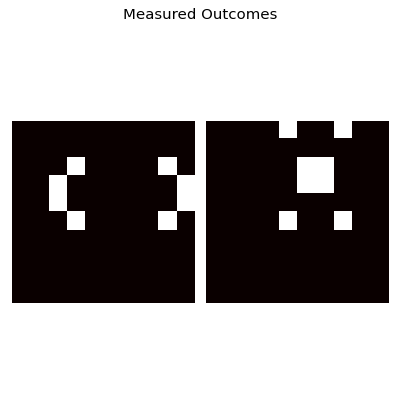

In [14]:
# run simulation again without plotting
initial_condition = "superposition"

# use 10x10 grid of qubits
GRID_SIZE = 10

NUM_FRAMES = 7

for n in range(NUM_FRAMES): 
    sim_result, measured_configs = run_simulation(QRITTERS, initial_condition, flicker=True, grid_size=GRID_SIZE, num_frames=n)

# plot all measured outcomes
# in the case of the superposition, there are only two:
assert(len(measured_configs) == 2)

fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(5,5))
ax0.axis('off')
ax1.axis('off')
ax0.imshow(measured_configs[0], cmap="hot", vmin=0, vmax=1, interpolation=None)
ax1.imshow(measured_configs[1], cmap="hot", vmin=0, vmax=1, interpolation=None)
fig.suptitle('Measured Outcomes')
fig.tight_layout()

So we notice that the only two states which were ever measured at frame 7 were precisely those which were measured when we simulated each of the scattering events individually. We always measure either the outcome of the "far" scattering OR the outcome of the "close" scattering. In this experiment we got the "close" outcome about 40% of the time and the "far" outcome about 60% of the time.

The important thing to notice is that, if after the quantum scattering we measured a glider heading off to the left, we always measured another one heading off to the right. If instead we measured a glider heading upward, there was always another heading downward. We never measure e.g. one glider going off to the left and another heading upward which would be some mixture of the "close" and "far" evolutions. The final positions of the two gliders have thus been shown empirically in this experiment to be correlated quantum mechanically. 

In other words, we have shown that the two gliders have become entangled after the scattering!

## Conclusions

In this notebook we achieved the immediate goal of the Qritters project. We implemented a quantum cellular automaton, which is a simple "quantization" of the classical Critters automaton. We then successfully simulated two "gliders" which exist in the model interacting and becoming entangled with one another. 

In the work that follows, we will expand on this simple idea and explore more variants of the Qritters update rule, as well as investigating different initial conditions and entanglement measures.